In [1]:
path = "drive/My Drive/Colab Notebooks/466-proj2/"
f = open(path + 'readme.txt', 'r')
print(f.read())
f.close()

Digital Democracy Data Sets (for Project 2 groups)
The ordering for the tsv as well as what each represents (committee_utterance file)

1)vid                   - Video Id
2)fileid                - YouTube Id
3)cid                   - Committee Id
4)c_name                - Committee Name
5)c_house               - Committee House
6)hid                   - Hearing Id
7)position              - Order of bills discussed in the hearing/video order
8)pid                   - Person Id
9)diarization_id        - Id of a speaker given perfect diarization
10)last                 - Speaker last name
11)first                - Speaker first name
12)start                - Start time of utterance
13)end                  - End time of utterance
14)utterance_order      - Order of the utterance in a given hearing
15)text                 - Text of the utterance

DDDataSet_3.tsv

Use this data set for your baseline machine learning analysis of speaker identification. There are about 10,000 randomly selected 

In [2]:
FILE = "committee_utterances.tsv"

import pandas as pd

df = pd.read_csv(path + FILE, sep='\t')
df

,vid,fileid,cid,c_name,c_house,hid,position,pid,diarization_id,last,first,start,end,utterance_order,text
0,4527,8xcAFOvPC50,2,Agriculture,Assembly,648,1,95,1,Galgiani,Cathleen,6,24,1,"Go ahead and call the hearing to order, our sp..."
1,4527,8xcAFOvPC50,2,Agriculture,Assembly,648,1,95,1,Galgiani,Cathleen,24,41,2,But also to the communities and it's had other...
2,4527,8xcAFOvPC50,2,Agriculture,Assembly,648,1,95,1,Galgiani,Cathleen,41,56,3,limited water resources are all challenges tha...
3,4527,8xcAFOvPC50,2,Agriculture,Assembly,648,1,95,1,Galgiani,Cathleen,56,71,4,"And we've invited expert witnesses, who'll dis..."
4,4527,8xcAFOvPC50,2,Agriculture,Assembly,648,1,95,1,Galgiani,Cathleen,71,88,5,Drought is certainly a critical issue for Cali...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30858,2858,nMgNQIdoyHs,148,Public Health and Developmental Services,Senate,497,4,103,1,Hernandez,Ed,1485,1494,555,"Current vote count is 9-3, and that bill is ou..."
30859,2858,nMgNQIdoyHs,148,Public Health and Developmental Services,Senate,497,4,2998,4,Secretary,Committee,1494,1498,556,Anderson? Mitchell? (aye) Moorlach?
30860,2858,nMgNQIdoyHs,148,Public Health and Developmental Services,Senate,497,4,103,1,Hernandez,Ed,1504,1512,557,Current vote count is 9-2. That bill is out. I...
30861,2858,nMgNQIdoyHs,148,Public Health and Developmental Services,Senate,497,4,2998,4,Secretary,Committee,1512,1521,558,Morrell? (no) Anderson? Mitchell? (aye) 9-3.


In [167]:
#Select a random 25% (1/4) of the content
import random
from pprint import pprint

records = list(df.text)
number_selected = len(records) // 16  #TODO CHANGE THIS VALUE TO 4
selected_records = random.sample(records, number_selected) #get random sample of number_selected records without replacement

utterances = [record for record in selected_records] #get all the utterance fields only (column #15) for clustering
print("total number of points:",len(utterances))

total number of points: 1928


In [106]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.corpus import wordnet 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 
punctuation = "-!?;:\"\'.,"

def getPOS(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def getFeatures(text):
    features = {}
    tokens = nltk.word_tokenize(text.lower())
    tot_cnt = len(tokens)
    for word in tokens:        
        if word.isnumeric():
            label = '[NUMBER]'
            if label not in features:
                features[label] = 1/float(tot_cnt)    
            else:
                features[label] += 1/float(tot_cnt)    
        elif word not in stop_words and word not in punctuation:
            w = wordnet_lemmatizer.lemmatize(word, getPOS(word))
            if w not in features:
                features[w] = 1/float(tot_cnt)
            else:
                features[w] += 1/float(tot_cnt)
    return features


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
import numpy as np
import random, sys, copy
from collections import Counter

max_t = -1   # max itterations (ignores threshold) (-1 to unset)10

def initCentroids(vec_data, k):
    centroidID = np.random.permutation(len(vec_data))[:k]
    print(centroidID)
    return [vec_data[cID] for cID in centroidID]

def calculateDistance(v_dict, u_dict):
    v = list(v_dict.values())
    u = list(u_dict.values())
    total = 0
    for i in range(0, len(v)):
        total += ((v[i] - u[i]) ** 2)
    return np.sqrt(total)


# takes a vector dictionary and a set of all the keys
# returns a new vector dictionary with all the keys
def reshapeVectDict(vect_dict, keys):
    result = copy.deepcopy(vect_dict)
    for key in keys:
        if key not in result:
            result[key] = 0.0
    return result

# For a given point, find the closest centroid from the list, return centroid's index
def closestCentroid(point, k, data):
    # Get all the keys (words) in the point and centroids
    # This will be used to transform them to the same dimension so we can do math
    all_keys = []
    all_keys.extend(point)        
    for cID in range(0,k):        
        all_keys.extend(data[cID].keys())
    all_keys = set(all_keys)

    closestCentroid = 0
    minDist = sys.maxsize
    point_reshape = reshapeVectDict(point, all_keys)

    # print()
    # print("point: ", point_reshape)
    for cID in range(0,k):
        centroid = data[cID]
        centroid_reshape = reshapeVectDict(centroid, all_keys)
        dist = calculateDistance(point_reshape, centroid_reshape)

        # print("dist: ", dist, "centroid: ", centroid)
        if (dist < minDist):
            minDist = dist          
            closestCentroid = cID

    # print("closestCentroid: ", closestCentroid, "minDist: ", minDist)
    return closestCentroid

def recalculateCentroid(cluster, data):
    new_centroid = {}
    for idx in cluster:
        point = data[idx]
        new_centroid = dict(Counter(new_centroid) + Counter(point))

    for key in new_centroid:
        new_centroid[key] /= len(cluster)
    # print("new_centroid: ", new_centroid)
    return new_centroid

def calculateConvergence(k, t, M):
    difference = 0
    for i in range(0, k):
        v = list(M[t][i].values())
        u = list(M[t-1][i].values())
        diff = (np.mean(u) - np.mean(v)) ** 2
        difference += diff
        print("diff: ", diff)
    print("difference: ", difference)
    return difference

def k_means(vec_data, k, e):
    M = []
    M.append([0 for i in range(0, k)])

    t = 0
    M[t] = initCentroids(vec_data, k)

    # if max_t >= 0:        
    #     while (t < max_t):
    #         print("iteration: ", t)
    #         t += 1
    #         M.append([0 for i in range(0, k)])    # M needs t rows
    #         C = []
    #         for i in range(0, k):
    #             C.append([])
    #         # Centroid assignment
    #         for point in vec_data:
    #             clusterID = closestCentroid(point, k, M[t-1])                
    #             C[clusterID].append(vec_data.index(point))    # keep track of the point's as indices
    #         print(len(C), C)
            
    #         # Centroid update
    #         for i in range(0, k):
    #             new_centroid = recalculateCentroid(C[i], vec_data)
    #             M[t][i] = new_centroid
    # else:
    while(calculateConvergence(k, t, M) < e):
        print("iteration: ", t)
        t += 1
        M.append([0 for i in range(0, k)])    # M needs t rows
        C = []
        for i in range(0, k):
            C.append([])
        # Centroid assignment
        for point in vec_data:
            clusterID = closestCentroid(point, k, M[t-1])                
            C[clusterID].append(vec_data.index(point))    # keep track of the point's as indices
        print(len(C), C)
        
        # Centroid update
        for i in range(0, k):
            new_centroid = recalculateCentroid(C[i], vec_data)
            M[t][i] = new_centroid 
    
    return C

In [132]:
recalculateCentroid([22, 11, 8], vec_data)

new_centroid:  {'whether': 0.011494252873563218, 'program': 0.011494252873563218, 'obviously': 0.011494252873563218, 'design': 0.011494252873563218, 'many': 0.011494252873563218, 'year': 0.011494252873563218, 'decade': 0.011494252873563218, 'ago': 0.011494252873563218, 'suitable': 0.011494252873563218, '21st': 0.011494252873563218, 'century': 0.011494252873563218, 'fair': 0.011494252873563218, 'question': 0.011494252873563218, 'cost': 0.009259259259259259, 'true': 0.009259259259259259, "'s": 0.03367003367003367, 'get': 0.009259259259259259, 'go': 0.009259259259259259, 'bank': 0.018518518518518517, 'loan': 0.009259259259259259, 'money': 0.009259259259259259, "n't": 0.009259259259259259, 'know': 0.009259259259259259, 'big': 0.009259259259259259, 'concern': 0.009259259259259259, 'file': 0.030303030303030304, 'item': 0.030303030303030304, '[NUMBER]': 0.030303030303030304, 'pas': 0.015151515151515152, 'retain': 0.015151515151515152, 'move': 0.015151515151515152, 'ab': 0.015151515151515152, 

{"'s": 0.03367003367003367,
 '21st': 0.011494252873563218,
 '987.': 0.015151515151515152,
 '[NUMBER]': 0.030303030303030304,
 'ab': 0.015151515151515152,
 'ago': 0.011494252873563218,
 'bank': 0.018518518518518517,
 'big': 0.009259259259259259,
 'century': 0.011494252873563218,
 'clerk': 0.015151515151515152,
 'concern': 0.009259259259259259,
 'cost': 0.009259259259259259,
 'decade': 0.011494252873563218,
 'design': 0.011494252873563218,
 'fair': 0.011494252873563218,
 'file': 0.030303030303030304,
 'get': 0.009259259259259259,
 'go': 0.009259259259259259,
 'item': 0.030303030303030304,
 'know': 0.009259259259259259,
 'loan': 0.009259259259259259,
 'many': 0.011494252873563218,
 'money': 0.009259259259259259,
 'move': 0.015151515151515152,
 "n't": 0.009259259259259259,
 'obviously': 0.011494252873563218,
 'pas': 0.015151515151515152,
 'program': 0.011494252873563218,
 'question': 0.011494252873563218,
 'read': 0.015151515151515152,
 'retain': 0.015151515151515152,
 'suitable': 0.011494

In [169]:
data = selected_records
vec_data = [getFeatures(text) for text in data]
print(len(vec_data))
# vec_data

1928


In [170]:
import time

startTime = time.time()
endTime = time.time()

clusters = k_means(vec_data, 5, 1)

print(round(endTime - startTime,3),'seconds')

[ 631 1737  162  444 1364]
diff:  0.0
diff:  0.0
diff:  0.0
diff:  0.0
diff:  0.0
difference:  0.0
iteration:  0
5 [[17, 18, 25, 45, 53, 65, 66, 71, 81, 83, 101, 113, 118, 134, 136, 137, 141, 161, 165, 194, 208, 217, 226, 246, 257, 273, 279, 71, 294, 318, 321, 327, 335, 336, 348, 352, 361, 365, 367, 372, 376, 378, 379, 382, 391, 401, 404, 433, 438, 449, 462, 463, 464, 471, 482, 534, 543, 554, 561, 587, 615, 618, 630, 554, 53, 680, 684, 554, 717, 720, 730, 757, 774, 792, 794, 65, 814, 815, 680, 848, 861, 870, 875, 884, 932, 983, 989, 1012, 1029, 1041, 1056, 1060, 1074, 1076, 1079, 1080, 1109, 1117, 1132, 1145, 1147, 1160, 1164, 1206, 1215, 1225, 1253, 1255, 1272, 1276, 1277, 1286, 1287, 361, 471, 1317, 1318, 1322, 1340, 1347, 1349, 1353, 1356, 165, 1370, 1391, 1394, 1404, 1408, 1409, 1416, 1417, 1427, 1434, 1436, 1439, 1449, 680, 1498, 1516, 1519, 1542, 71, 1581, 1607, 1624, 1628, 680, 1647, 1651, 65, 1670, 1695, 1697, 1707, 1719, 1720, 1795, 1819, 1836, 1854, 1859, 1860, 1870, 361, 187

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [171]:
for IDX in range(0, len(clusters)):
    print("Cluster ", IDX, " contains:")
    samples = [vec_data[i] for i in clusters[IDX]]
    print(samples)

Cluster  0  contains:
[{'original': 0.03225806451612903, 'rubber': 0.03225806451612903, 'installation': 0.03225806451612903, 'would': 0.03225806451612903, 'probably': 0.03225806451612903, 'look': 0.03225806451612903, 'particular': 0.03225806451612903, 'component': 0.03225806451612903, 'job': 0.03225806451612903, "'re": 0.03225806451612903, 'somewhere': 0.03225806451612903, 'around': 0.03225806451612903, '$': 0.03225806451612903, '60,000': 0.03225806451612903, 'whole': 0.03225806451612903, 'process': 0.03225806451612903}, {'enrique': 0.03333333333333333, 'ruacho': 0.03333333333333333, 'california': 0.03333333333333333, 'association': 0.03333333333333333, 'school': 0.03333333333333333, 'business': 0.03333333333333333, 'official': 0.03333333333333333, 'oppose': 0.03333333333333333, 'remove': 0.03333333333333333, 'opposition': 0.03333333333333333, 'encourage': 0.03333333333333333, 'statement': 0.03333333333333333, 'prior': 0.03333333333333333, 'colleague': 0.03333333333333333}, {'low': 0.0

In [0]:
plt.scatter()

In [0]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize


vectorizer = DictVectorizer()
vec_data = vectorizer.fit_transform(map(getFeatures, data))

tf_idf_vectorizor = TfidfVectorizer(analyzer=getFeatures,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [0]:
from sklearn.cluster import KMeans
from sklearn import decomposition

sklearn_pca = decomposition.PCA(n_components = 2)

Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [192]:
tf_idf_vectorizor.inverse_transform(prediction)

[array(["''", "'no", "'shoot", "'transfixed", '0.10', '1,000', '10-year',
        '11400s', '125,000,000', '139,000', '1526.', '17th', '1960s',
        '1990.', '19th', '2,500', '2.211', '20.', '2015.', "2016-'17",
        '21.', '22nd', '24/7', '26.', '2nd', '30.', '3rd', '400,000',
        '437.', '540,000', '6.6', '61,000', '7,000', '7-1.', '74,417',
        '8,000', '8.', '868,000', '914.', '929.', '953.', '967.', '[',
        'ab503', 'ability', 'able', 'accept', 'accessible', 'accord',
        'account', 'accountability', 'accuracy', 'acquire', 'acre',
        'actor', 'adaptive', 'addictive', 'adjudicate', 'adjust',
        'adjustment', 'administratively', 'advent', 'affirmatively',
        'affordability', 'afraid', 'ag', 'againm', 'agent', 'aggressively',
        'airline', 'allegation', 'alliance', 'allocate', 'allred',
        'already', 'alternative', 'although', 'amber', 'ambitious', 'amen',
        'amenity', 'ana', 'analysis', 'animal', 'another', 'anti-anxiety',
      

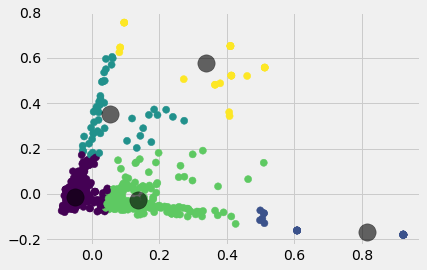

In [194]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);